<h1 style='color: darkmagenta; font-size: 36px; font-weight: bold;'>Machine Learning - Twitter Sentiment Analysis</h1>

# <font color='purple' style='font-size: 20px;'>Goal:</font>
<hr style='border: 1px solid darkorchid;'>
   <span style="line-height:25px; text-align:justify">The goal of this notebook is to treat the tweets text in the dataset and build a Logistic Regression Model to classify tweets in 0-Negative or 1-Positve. The base dataset was labelled manually to improve the model accuracy.
    </span>
<hr style='border: 1px solid darkorchid;'>

In [1]:
# Import the first dependencies
import pandas as pd
import numpy as np
import re

# Open the file labelled manually. It will be base to create our model.
df_tweets = pd.read_csv("./data/tweets_labelled_same_opinion.csv")

# Shuffle the DF before start the process
df_tweets = df_tweets.sample(frac=1)

df_tweets

,id,label,tweet
785,5dcaf686c14b24d0701c03ee,0,RT @SethMacFarlane: Fox â€” The company I work...
213,5dcabb42dd8a420f9f1d56e7,0,RT @CarmineSabia: President Donald Trump walks...
31,5dcaf688c14b24d0701c0412,1,@redsteeze Imagine being mad about the media h...
390,5dcaf693c14b24d0701c04e8,1,RT @GretaThunberg: Today at 11:30 I and 15 oth...
984,5dcaf696c14b24d0701c0513,0,"RT @WashTimes: Greta Thunberg, a parentâ€™s ni..."
...,...,...,...
352,5dcaf683c14b24d0701c03bc,1,RT @funder: The world is Greta Thunberg rn. ht...
1022,5dcabb4edd8a420f9f1d57d7,0,"RT @WIRED: â€People are suffering, people are..."
521,5dcaf681c14b24d0701c0399,0,RT @MarkDice: Teenage activist Greta Thunberg ...
903,5dcabb42dd8a420f9f1d56df,0,RT @TwitterMoments: â€œWe are in the beginning...


In [2]:
# To have a better accuracy the proportion should be balanced to 50% pos / 50% neg
print(df_tweets["label"].value_counts()) 

0    765
1    296
Name: label, dtype: int64


In [3]:
# BAG OF WORDS - Must be created every time we introduce new data on our pipeline.
from sklearn.feature_extraction.text import CountVectorizer
vectorize = CountVectorizer(lowercase = True, max_features = 1300)

bag_of_words = vectorize.fit_transform(df_tweets["tweet"])

In [4]:
print(bag_of_words.shape)

(1061, 1300)


In [5]:
# Create a Logistic Regression Model
from sklearn.model_selection import train_test_split

train, test, class_train, class_test = train_test_split(bag_of_words,
                                                        df_tweets["label"],
                                                        random_state = 42)

In [6]:
# See how our data is divided between train and test.
print(train.shape) # 75% 
print(test.shape)  # 25%

(795, 1300)
(266, 1300)


### Functions to help us analize the data and decide next treatment on the pipeline

In [7]:
# Function to create our word cloud chart
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def wordCloud_chart(df, text_column, label_value):
    qry_result = df.query("label == " + label_value)
    all_words = ' '.join([text for text in qry_result[text_column]])
    word_cloud = WordCloud(width = 800, height = 500,
                                max_font_size=110, collocations=False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [8]:
# Function to create our Pareto bar chart 
def pareto(df, text_column, num_rows):
    all_words = ' '.join([text for text in df[text_column]])
    frequency = nltk.FreqDist(token_space.tokenize(all_words))
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                 "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = num_rows)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x= "Word", y = "Frequency")
    ax.set(ylabel = "Count")
    plt.show() 

In [9]:
# Function to calculate the accuracy  
from sklearn.linear_model import LogisticRegression
def calc_accuracy(df, text_column, label):
    vectorizer = CountVectorizer(lowercase=True, max_features=1300)
    
    bag_of_words = vectorizer.fit_transform(df[text_column])
    train, test, class_train, class_test = train_test_split(bag_of_words,
                                                            df[label],
                                                            random_state = 42)
        
    logistic_regression = LogisticRegression(solver="lbfgs")
    logistic_regression.fit(train, class_train)
    
    # return the accuracy
    return logistic_regression.score(test, class_test)

### First analysis before start data treatment 

In [10]:
first_accuracy = calc_accuracy(df_tweets, 'tweet' ,'label')
first_accuracy

0.8571428571428571

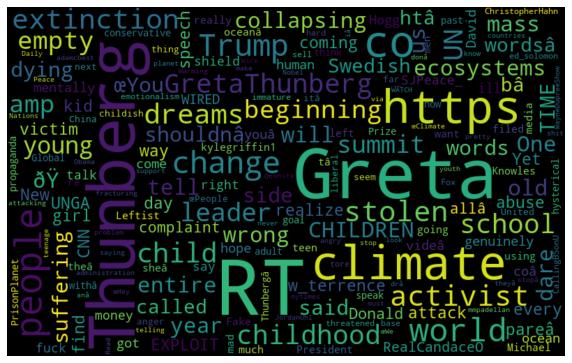

In [11]:
# wordCloud of negative tweets
wordCloud_chart(df_tweets, 'tweet' ,'0')

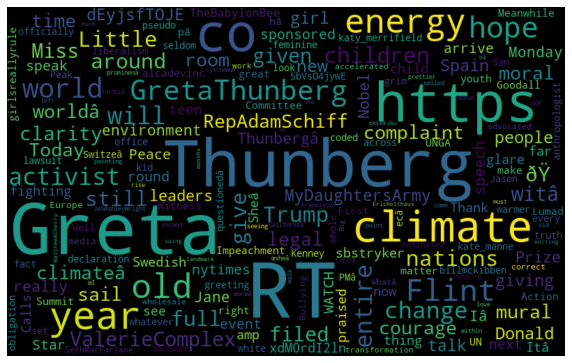

In [12]:
# wordCloud of positive tweets
wordCloud_chart(df_tweets, 'tweet' ,'1')

### Tokenization

In [13]:
from nltk import tokenize
import nltk

token_space = tokenize.WhitespaceTokenizer()
all_words = ' '.join([text for text in df_tweets["tweet"]])
frequency = nltk.FreqDist(token_space.tokenize(all_words))
df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                             "Frequency": list(frequency.values())})

In [14]:
df_frequency = df_frequency.nlargest(columns = "Frequency", n = 10)
df_frequency

,Word,Frequency
0,RT,934
30,Greta,720
18,the,717
31,Thunberg,515
53,is,455
15,a,405
13,to,370
17,of,364
188,are,321
61,and,315


### First treatment: remove words, characters, and patterns typical of tweets 

In [15]:
# Function to remove links and ampersand
def clear_text(df, column):
    for index, row in df.iterrows():
        # Remove links 
        df.loc[index, column] = re.sub(r'https?://\S+', '', df.loc[index, column], flags=re.MULTILINE)
        df.loc[index, column] = re.sub(r'http?://\S+', '',  df.loc[index, column], flags=re.MULTILINE)
        # Remove ampersand pattern
        df.loc[index, column] = re.sub('&amp;', '',         df.loc[index, column], flags=re.MULTILINE)

clear_text(df_tweets, 'tweet')

In [16]:
# Function to remove some patterns
def remove_pattern(text, pattern):
    print(text)
    # Find the pattern
    r = re.findall(pattern, text)
    
    # Removes the pattern from the sentence
    for i in r:
        text = re.sub(i,"",text)
    
    return text

In [17]:
# NumPy Vectorization is much more faster than traditional for loops when we work with large datasets
# Remove "@user" pattern 
df_tweets['treatment_1'] = np.vectorize(remove_pattern)(df_tweets['tweet'], "@[\w]*")
df_tweets['treatment_1'] = np.vectorize(remove_pattern)(df_tweets['treatment_1'], "RT :*")

# Remove punctuation, numbers, and special characters
df_tweets['treatment_1'] = df_tweets['treatment_1'].str.replace("[^a-zA-Z#]", " ")

df_tweets['treatment_1']

RT @SethMacFarlane: Fox â€” The company I work with. Really classy, guys. Proud to be a part of the team. Jesus H. Christ.

RT @SethMacFarlane: Fox â€” The company I work with. Really classy, guys. Proud to be a part of the team. Jesus H. Christ.

RT @CarmineSabia: President Donald Trump walks past Greta Thunberg because he does not bow to 16 year olds. 
@redsteeze Imagine being mad about the media hypothetically bullying an imaginary teenager when the media is busy bâ€¦ 
RT @GretaThunberg: Today at 11:30 I and 15 other children from around the world filed a legal complaint against 5 nations over the climateâ€¦
RT @WashTimes: Greta Thunberg, a parentâ€™s nightmare -  - @washtimes @ckchumley: "This is how kids act when they arenâ€¦
RT @mmpadellan: The Climate Change Denier in Chief wants a Nobel Peace Prize, but his admin has overturned almost all of Obama's environmenâ€¦
RT @PrisonPlanet: Greta Thunberg (the people using her as a child human shield for their hysterical propaganda) has 

RT : â€œPeople are suffering. People are dying. Entire ecosystems are collapsing. We are in the beginning of a mass extinction.â€¦
RT : "You have stolen my dreams and my childhood with your empty words," climate activist Greta Thunberg tells the UN. "We are in the bâ€¦
RT : â€œThe Hambach Forest is so important because itâ€™s so symbolic,â€

â€œI have visited coal mines before, but this was so huge anâ€¦
RT : Sorry, unpopular opinion again, but this whole Greta Thunberg thing is a crock too. It's disgusting to use children to fâ€¦
 How embarrassing for their family and especially their children.
RT : Greta Thunberg, who suffers from an anxiety disorder, tells world leaders at the UN: â€œYou have stolen my dreams and my childâ€¦
RT : We are all Greta Thunberg.
 
Might want to consider taking that down before the building  commits suicide?
RT : Oh lord above.

Which countries are Greta Thunberg targeting for climate sins?

Germany, France, Brazil, Argentina andâ€¦
RT : â€People are suf

785      Fox     The company I work with  Really class...
213      President Donald Trump walks past Greta Thunb...
31       Imagine being mad about the media hypothetica...
390      Today at       I and    other children from a...
984      Greta Thunberg  a parent   s nightmare       ...
                              ...                        
352                      The world is Greta Thunberg rn  
1022        People are suffering  people are dying  en...
521      Teenage activist Greta Thunberg is very upset...
903         We are in the beginning of a mass extincti...
696      One day  #GretaThunberg will realize that she...
Name: treatment_1, Length: 1061, dtype: object

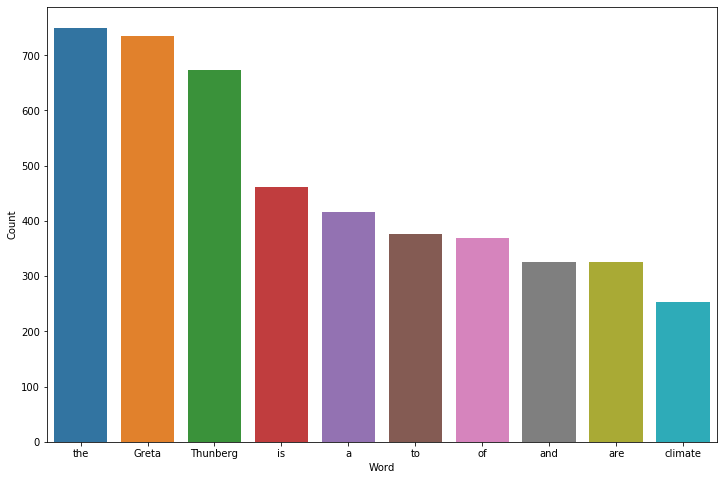

In [18]:
# Get the top 10 words
pareto(df_tweets, 'treatment_1', 10)

In [19]:
second_accuracy = calc_accuracy(df_tweets, 'treatment_1' ,'label')
print("Accuracy evolution {}, {}".format(first_accuracy,second_accuracy))

Accuracy evolution 0.8571428571428571, 0.8796992481203008


### Second treatment: Removing stop words

In [20]:
stopwords = nltk.corpus.stopwords.words("english")
new_tweets = list()

for tweet in df_tweets["treatment_1"]:
    new_phrase = list()
    text_words = token_space.tokenize(tweet.lower())
    for word in text_words:
        if word not in stopwords:
            new_phrase.append(word)
    new_tweets.append(' '.join(new_phrase))
    
df_tweets["treatment_2"] = new_tweets

In [21]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [22]:
third_accuracy = calc_accuracy(df_tweets, "treatment_2", "label")
print("Accuracy evolution {}, {}, {}".format(first_accuracy,second_accuracy, third_accuracy))

Accuracy evolution 0.8571428571428571, 0.8796992481203008, 0.8571428571428571


### Negative wordCloud

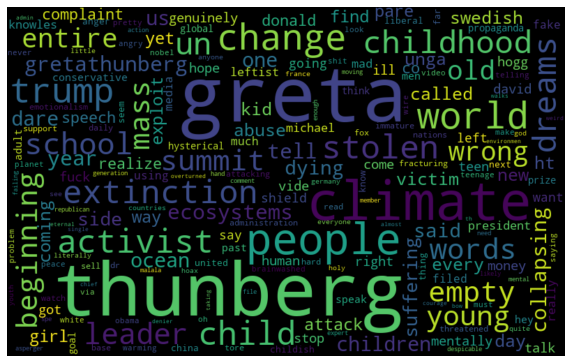

In [23]:
wordCloud_chart(df_tweets, "treatment_2", '0')

### Positive wordCloud

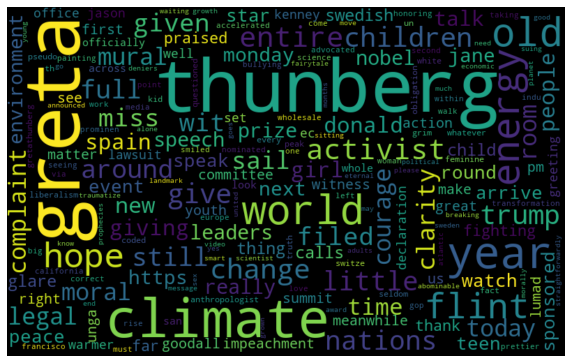

In [24]:
wordCloud_chart(df_tweets, "treatment_2", '1')

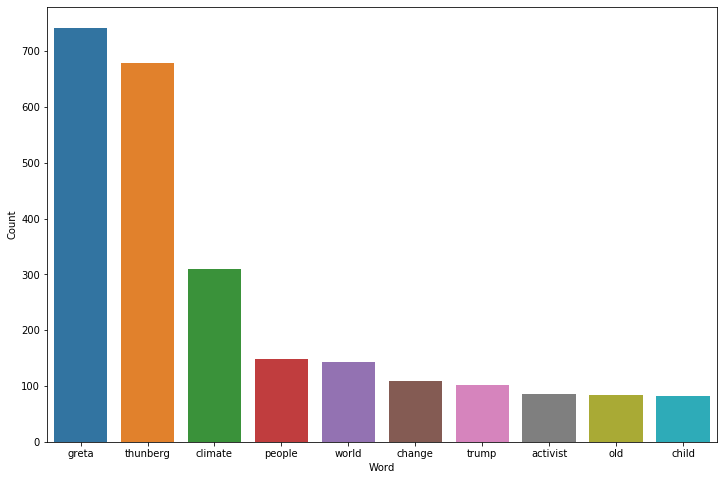

In [25]:
pareto(df_tweets, "treatment_2", 10)

### Third treatment: Stemming

In [26]:
from nltk import PorterStemmer # Basically transform variation of words like gerund in the root word.   
ps = PorterStemmer()

tokenized_tweet = df_tweets['treatment_2'].apply(lambda x: x.split())
tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])

tokenized_tweet.head()

785    [fox, compani, work, realli, classi, guy, prou...
213    [presid, donald, trump, walk, past, greta, thu...
31     [imagin, mad, media, hypothet, bulli, imaginar...
390    [today, children, around, world, file, legal, ...
984        [greta, thunberg, parent, nightmar, kid, act]
Name: treatment_2, dtype: object

In [27]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

df_tweets['treatment_3'] = tokenized_tweet
    
fourth_accuracy = calc_accuracy(df_tweets, "treatment_3", "label")

In [28]:
print("Accuracy evolution {}, {}, {}, {}".format(first_accuracy,second_accuracy, third_accuracy, fourth_accuracy))

Accuracy evolution 0.8571428571428571, 0.8796992481203008, 0.8571428571428571, 0.8421052631578947


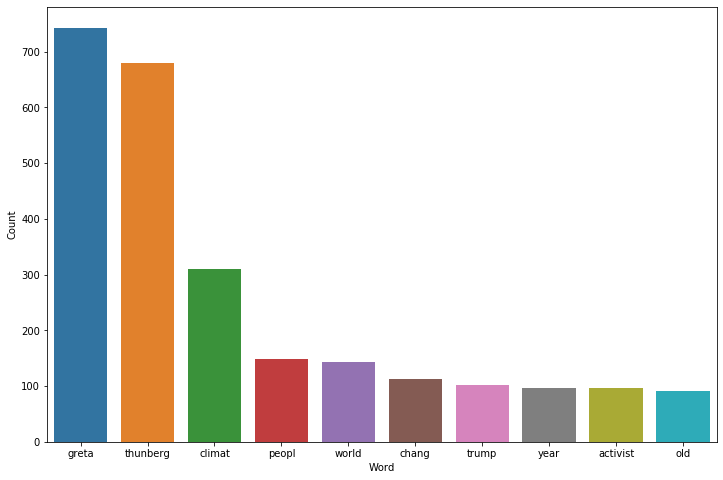

In [29]:
pareto(df_tweets, "treatment_3", 10)

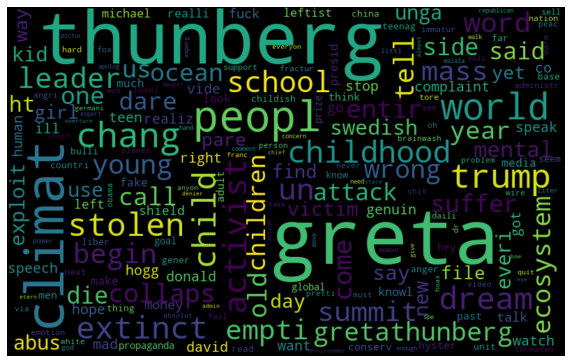

In [30]:
wordCloud_chart(df_tweets, "treatment_3","0")

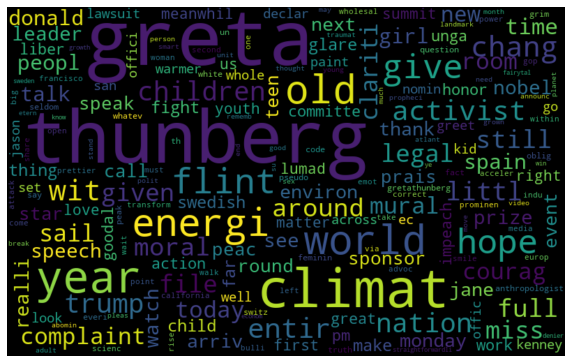

In [31]:
wordCloud_chart(df_tweets, "treatment_3","1")

In [32]:
# Last trainning to create the model
vectorizer = CountVectorizer(lowercase=True, max_features=1300)

bag_of_words = vectorizer.fit_transform(df_tweets["treatment_3"])
train, test, class_train, class_test = train_test_split(bag_of_words,
                                                        df_tweets['label'],
                                                        random_state = 42)
logistic_regression = LogisticRegression(solver="lbfgs")
logistic_regression.fit(train, class_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
# Save and load the model
import pickle
filename = './models/tweet_model_curr_model.sav'
# pickle.dump( logistic_regression , open(filename, 'wb'))
# load the model from disk
model = pickle.load(open(filename, 'rb'))

# df_tweets.to_csv("./models/to_test.csv")

### Test the model with new phrases

In [34]:
# Shuffle the DF 
df_tweets = df_tweets.sample(frac=1)
df_tweets

# Insert new text to test the model.
text = [999, None, '' , '', '' ,'greta is a good girl']
df_tweets.iloc[0] = text

In [35]:
# Test the model
newbag_of_words = vectorizer.fit_transform(df_tweets['treatment_3'])

result = model.predict(newbag_of_words)

In [36]:
df_tweets.head()

,id,label,tweet,treatment_1,treatment_2,treatment_3
449,999,NaN,,,,greta is a good girl
298,5dcabb44dd8a420f9f1d570b,1.0,RT @DougKass: A sixteen year old with Asperger...,A sixteen year old with Aspergers Greta Thun...,sixteen year old aspergers greta thunberg sing...,sixteen year old asperg greta thunberg singula...
311,5dcaf680c14b24d0701c0377,0.0,RT @ed_solomon: The people who got mad at or t...,The people who got mad at or threatened by Gr...,people got mad threatened greta thunberg anger...,peopl got mad threaten greta thunberg anger em...
674,5dcca68ef372816fadd094b0,0.0,RT @ProudGayPatriot: Is it wrong to hope this ...,Is it wrong to hope this little Hansel and Gr...,wrong hope little hansel gretel chick hits ice...,wrong hope littl hansel gretel chick hit icebe...
1033,5dcca67df372816fadd094a9,0.0,shawty want it to be 1492 so bad ðŸ˜‚ðŸ˜‚ henr...,shawty want it to be so bad henr...,shawty want bad henry hudson headass,shawti want bad henri hudson headass


In [37]:
# Print the result 0-Negative 1-Positive
result[0] 

1

### Create a new flag at MongoDB to store the model prediction for each tweet. 

In [38]:
import pymongo
import time
import argparse
import json
import string
from dateutil import parser as psr
from datetime import datetime
from config import dbname, dbuser, psswd, host, parameters
from bson.objectid import ObjectId
from pprint import pprint


connection_string ='mongodb+srv://' + dbuser + ':' + psswd + host + '/' + dbname + "?" + parameters
mongo_client = pymongo.MongoClient(connection_string)


In [39]:
new_bag_of_words = vectorizer.fit_transform(df_tweets["treatment_1"])
result = model.predict(new_bag_of_words)

for index, row in df_tweets.iterrows():
    
    print("index {}, ID {}, label {}, result {},  {} ".format(index, df_tweets.loc[index, 'id'], \
                                                      df_tweets.loc[index, 'label'], result[index], \
                                                      df_tweets.loc[index, 'tweet']))
    
    try:
        with mongo_client:
            db = mongo_client.dbAI
            currId = ObjectId(df_tweets.loc[index, 'id'])

            # Run query
            db_tweets = db.twitter.find({ '_id': currId }, { "_id": 1 })
            tweet = list(db_tweets)

            # save label sentiment analysis in mongoDB
            db.twitter.update_one({
             "_id": currId
            },{
              '$set': {
                'model_sent_an': str(result[index])
              }
            })

    except:    
        print(f"We got a error.")
    

index 449, ID 999, label nan, result 0,   
We got a error.
index 298, ID 5dcabb44dd8a420f9f1d570b, label 1.0, result 0,  RT @DougKass: A sixteen year old with Aspergers, Greta Thunberg,  is singularly driving the right out of their minds. 
index 311, ID 5dcaf680c14b24d0701c0377, label 0.0, result 1,  RT @ed_solomon: The people who got mad at or threatened by Greta Thunbergâ€™s anger  emotionalism and called it childish  immature are theâ€¦ 
index 674, ID 5dcca68ef372816fadd094b0, label 0.0, result 0,  RT @ProudGayPatriot: Is it wrong to hope this little Hansel and Gretel chick hits an iceberg on her way there?

 
index 1033, ID 5dcca67df372816fadd094a9, label 0.0, result 0,  shawty want it to be 1492 so bad ðŸ˜‚ðŸ˜‚ henry hudson headass 
index 751, ID 5dcabb4ddd8a420f9f1d57d0, label 0.0, result 1,  RT @ResisterSiano: Raise your hand if you think Greta Thunberg is more intelligent than every member of the GOP. 
index 692, ID 5dcca6e0f372816fadd094c8, label 0.0, result 0,  RT @radisson52

index 163, ID 5dcabb43dd8a420f9f1d5702, label 1.0, result 0,  RT @AuthorKimberley: "On Monday, Greta Thunberg and 15 other young people filed a potentially world-changing lawsuit. 

They announced thatâ€¦ 
index 198, ID 5dcaf688c14b24d0701c0414, label 0.0, result 0,  RT @business: Greta Thunberg is right, world leaders say: We are failing   
index 334, ID 5dcca6f2f372816fadd094cf, label 1.0, result 0,  RT @Franklin_Graham: Want to go shopping with @Greta Van Susteren and @JohnPCoale for shoebox gifts for @SamaritansPurse @OCC_Shoeboxes? Châ€¦ 
index 398, ID 5dcabb4edd8a420f9f1d57db, label 1.0, result 0,  RT @GretaThunberg: Today at 11:30 I and 15 other children from around the world filed a legal complaint against 5 nations over the climateâ€¦ 
index 128, ID 5dcaf697c14b24d0701c0528, label 0.0, result 0,  RT @ABC: Greta Thunberg at #UNGA: "This is all wrongâ€¦ You all come to us young people for hope. How dare you!"

"You have stolen my dreamsâ€¦ 
index 532, ID 5dc88578678e6d23f7706561

index 977, ID 5dc8859b678e6d23f7706579, label 0.0, result 0,  RT @walletcheck: liberals have decided that the only necessary measure to stop climate change is to appease the child god Greta with idolatâ€¦ 
index 70, ID 5dcaf686c14b24d0701c03f8, label 0.0, result 0,  He says this about Greta Thunberg, a young girl who understands what he doesnâ€™t, who speaks with an eloquence he doâ€¦  
index 675, ID 5dcca68ff372816fadd094b1, label 0.0, result 0,  RT @ProudGayPatriot: Is it wrong to hope this little Hansel and Gretel chick hits an iceberg on her way there?

 
index 101, ID 5dcabb3add8a420f9f1d5649, label 0.0, result 0,  RT @_SJPeace_: Greta Thunberg

"This is all wrong. I shouldnâ€™t be up here. I should be in school on the other side of the ocean. Yet you coâ€¦ 
index 556, ID 5dcaf690c14b24d0701c04b0, label 0.0, result 0,  RT @MikeCarlton01: ...which will no doubt bring forth another torrent of puerile abuse from Blot, Fido Kenny, Albrechtsen and the usual socâ€¦ 
index 223, ID 5dcaf6

index 414, ID 5dcabb3edd8a420f9f1d5692, label 0.0, result 0,  RT @Ian56789: Greta Thunberg's face after reading Ian56's evidence  fact based thread on Global Warming / Climate Change.

Greta Thunberg'â€¦ 
index 194, ID 5dcabb3bdd8a420f9f1d5662, label 0.0, result 0,  RT @BuckSexton: So weird how the â€œcant criticize kids ruleâ€ that the media enforces with dictatorial resolve is applicable to Greta Thunberâ€¦ 
index 436, ID 5dcabb4cdd8a420f9f1d57b2, label 0.0, result 0,  RT @jephjacques: Greta Thunberg is quite literally speaking truth to power and every shitty old white person on the planet is mad that sheâ€¦ 
index 75, ID 5dcaf682c14b24d0701c039d, label 1.0, result 0,  Iâ€™ve muted â€œGreta Thunberg.â€ Iâ€™m such a dreadful monster. 
index 1059, ID 5dcabb49dd8a420f9f1d576e, label 0.0, result 0,  Wow talk about you Democratsare doing just what HITLER did! Indoctrination of the youth! This girl is a brainwashedâ€¦  
index 421, ID 5dc8856b678e6d23f7706556, label 0.0, result 1,  RT @in

index 484, ID 5dcaf68fc14b24d0701c049d, label 1.0, result 0,  RT @kumparan: Greta the Great!  
index 295, ID 5dcaf68fc14b24d0701c049c, label 0.0, result 0,  RT @Dorling83: '16 year old Greta Thunberg is too young to make her own mind up and has been groomed' scream people who said that Shamima Bâ€¦ 
index 1004, ID 5dcabb3bdd8a420f9f1d565e, label 0.0, result 0,  RT @WIRED: â€People are suffering, people are dying, entire ecosystems are collapsing. We are in the beginning of a mass extinction and allâ€¦ 
index 516, ID 5dcaf693c14b24d0701c04da, label 0.0, result 0,  RT @Mandalorian_Ren: Michael Knowles calls Greta Thunberg "mentally ill". Let me tell him as a mother of a son with autism to fuck right ofâ€¦ 
index 597, ID 5dcabb3cdd8a420f9f1d566f, label 1.0, result 0,  RT @NBCNews: WATCH: Greta Thunberg passionately shares her message to world leaders at #UNGA:

"We'll be watching you ... You'll come to usâ€¦ 
index 232, ID 5dcca5bcf9456a4383899135, label 1.0, result 0,  RT @climatestewar

index 47, ID 5dcaf698c14b24d0701c0548, label 0.0, result 0,  FOX News Guest Michael Knowles Calls Climate Activist Greta Thunberg a "Mentally Ill" Child -- Liberal Hack EXPLODEâ€¦  
index 718, ID 5dcabb3add8a420f9f1d5646, label 0.0, result 0,  RT @RealSaavedra: This speech by far-left activist Greta Thunberg is absolute madness  
index 151, ID 5dcaf682c14b24d0701c03a6, label 1.0, result 1,  RT @alcadevinc: Greta Thunberg is being praised for fighting for the environment. 

Meanwhile, when Lumad youth speaks up, they are being pâ€¦ 
index 242, ID 5dcaf684c14b24d0701c03c0, label 0.0, result 0,  RT @CNN: "You have stolen my dreams and my childhood with your empty words," climate activist Greta Thunberg tells the UN. "We are in the bâ€¦ 
index 871, ID 5dcabb47dd8a420f9f1d5751, label 0.0, result 0,  RT @TIME: Greta Thunberg to world leaders at the U.N. climate summit: â€œYou have stolen my dreams and my childhood with your empty wordsâ€ htâ€¦ 
index 271, ID 5dcca5c0f9456a4383899137, label 

index 537, ID 5dcaf693c14b24d0701c04e3, label 1.0, result 0,  RT @MattWalshBlog: It may be a smart political move to traumatize children with these End Times prophecies, but it is morally abominable

hâ€¦ 
index 1054, ID 5dcabb52dd8a420f9f1d5826, label 0.0, result 0,  Video of Greta Thunberg crossing paths with Trump at UN goes viral  
index 227, ID 5dcca66ff372816fadd094a3, label 1.0, result 0,  RT @CFACT: Gretaâ€™s return boat, an Outremer 45, weighs 17,400 pounds and is made of fiberglass, or fiber-reinforced plastic.  The yacht wasâ€¦ 
index 186, ID 5dcaf694c14b24d0701c04f5, label 0.0, result 0,  RT @BorgJardin: @AynRandPaulRyan I canâ€™t wait for MORE @FoxNews sponsors to drop despicable Laura Ingraham who uses her @IngrahamAngle showâ€¦ 
index 842, ID 5dcabb42dd8a420f9f1d56e6, label 1.0, result 0,  RT @TheMominatrixx: GOP: 16-year-old girls are very mature; they can legally consent to sex + get married

Also GOP: 16 year-old Greta Thunâ€¦ 
index 56, ID 5dcaf687c14b24d0701c03fc, l

index 46, ID 5dcca693f372816fadd094b3, label 1.0, result 0,  Follow Greta across the ocean  
index 1010, ID 5dcaf690c14b24d0701c04b4, label 0.0, result 0,  RT @WIRED: â€People are suffering, people are dying, entire ecosystems are collapsing. We are in the beginning of a mass extinction and allâ€¦ 
index 634, ID 5dcabb3cdd8a420f9f1d566e, label 1.0, result 0,  RT @OliverMcGee: Retweet #GretaThunberg is a #ClimateChange Actor Play Acting at @UN!

TO SPEAK TO HER ELDERS SO HARSHLY at #ClimateActionSâ€¦ 
index 459, ID 5dcca76af372816fadd094f3, label 1.0, result 0,  RT @julientaming: I support her 200%.  
index 606, ID 5dcabb43dd8a420f9f1d56fa, label 0.0, result 0,  RT @NPR: "We are in the beginning of a mass extinction, and all you can talk about is money and fairy tales of eternal economic growth. Howâ€¦ 
index 82, ID 5dcabb49dd8a420f9f1d5779, label 0.0, result 1,  It's really disgusting that some people are making fun of Greta Thunberg, a 16 year old climate change activist witâ€¦  
ind

index 885, ID 5dcaf67fc14b24d0701c036b, label 0.0, result 0,  RT @timjacobwise: You can't have it both ways. You can't attack young folk for being self-absorbed  only concerned about makeup tutorials,â€¦ 
index 290, ID 5dcaf696c14b24d0701c051d, label 1.0, result 0,  RT @dianabutlerbass: Those commenting on Greta Thunberg would do well to remember that Joan of Arc led an army, Jane Austen wrote her 1st wâ€¦ 
index 544, ID 5dcaf683c14b24d0701c03b1, label 0.0, result 0,  RT @maykamaykaba: Reality check: The Filipino youth have been fighting for our environment, but the sad thing here is that unlike Greta Thuâ€¦ 
index 940, ID 5dcaf67fc14b24d0701c0365, label 1.0, result 0,  RT @ValerieComplex: I hope the same energy given to Greta Thunberg is the same energy you give to Little Miss Flint because Flint still witâ€¦ 
index 212, ID 5dcca5e4f9456a438389913e, label 0.0, result 1,  RT @CallingBSonU: The next goal of the Fake News will be a hard sell that Trump's base is fracturing  support for h

index 801, ID 5dcabb40dd8a420f9f1d56c9, label 0.0, result 0,  RT @StefanMolyneux: Oh lord above.

Which countries are Greta Thunberg targeting for climate sins?

Germany, France, Brazil, Argentina andâ€¦ 
index 1042, ID 5dcabb4cdd8a420f9f1d57b7, label 0.0, result 0,  The #Right - The left are bullying #GretaThunberg !
Also the #Right: Let's photoshop pictures of Greta looking old,â€¦  
index 247, ID 5dcabb47dd8a420f9f1d5756, label 0.0, result 0,  RT @CNN: "You have stolen my dreams and my childhood with your empty words," climate activist Greta Thunberg tells the UN. "We are in the bâ€¦ 
index 572, ID 5dcabb4ddd8a420f9f1d57c6, label 0.0, result 0,  RT @mmpadellan: The Climate Change Denier in Chief wants a Nobel Peace Prize, but his admin has overturned almost all of Obama's environmenâ€¦ 
index 652, ID 5dcabb3ddd8a420f9f1d5687, label 0.0, result 0,  RT @prageru: Despicable. 

Leftists are telling children, like Greta Thunberg, that climate change is going to kill them and everyone the

index 543, ID 5dcaf699c14b24d0701c0550, label 0.0, result 0,  RT @maykamaykaba: Reality check: The Filipino youth have been fighting for our environment, but the sad thing here is that unlike Greta Thuâ€¦ 
index 777, ID 5dcaf686c14b24d0701c03e8, label 1.0, result 0,  RT @sbstryker: Greta Thunbergâ€™s glare at Donald Trump is giving me the energy to get through this Monday  
index 579, ID 5dcabb48dd8a420f9f1d5769, label 0.0, result 0,  RT @MrAndyNgo: Greta Thunberg, who suffers from an anxiety disorder, tells world leaders at the UN: â€œYou have stolen my dreams and my childâ€¦ 
index 862, ID 5dcaf692c14b24d0701c04c9, label 0.0, result 0,  RT @TIME: Greta Thunberg to world leaders at the U.N. climate summit: â€œYou have stolen my dreams and my childhood with your empty wordsâ€ htâ€¦ 
index 486, ID 5dcabb3edd8a420f9f1d5696, label 0.0, result 0,  RT @kylegriffin1: Greta Thunberg at #UNGA: "This is all wrong. I shouldnâ€™t be up here. I should be in school on the other side of the oceanâ€

index 769, ID 5dcca6e3f372816fadd094ca, label 1.0, result 0,  RT @ryxcommar: Peak California liberalism is painting a mural honoring a 16 year-old climate activist within a year of her rise to prominenâ€¦ 
index 36, ID 5dcca721f372816fadd094e1, label 1.0, result 0,  @Steve_Jacboson @greta Yes. The helping verbs are be, am, is, are, was, were being, been. 
index 262, ID 5dcaf680c14b24d0701c0383, label 0.0, result 1,  RT @cnni: "You have stolen my dreams and my childhood with your empty words," climate activist Greta Thunberg tells the UN. "We are in theâ€¦ 
index 986, ID 5dcaf690c14b24d0701c04ad, label 0.0, result 1,  RT @WatcherDead: Trump steals demon-spawn Greta Thunberg's limelight during the UN Climate Action Summit


Pricelessâ€¦ 
index 548, ID 5dcaf695c14b24d0701c0500, label 1.0, result 0,  RT @MichaelSkolnik: Greta Thunberg. 

The whole speech. 

Watch every second of it. 

#UNGA   
index 61, ID 5dcaf680c14b24d0701c0376, label 0.0, result 0,  Greta Thunberg to world leaders: 'Ho

index 837, ID 5dcabb4add8a420f9f1d5792, label 0.0, result 0,  RT @thehill: WATCH: Greta Thunberg tears into world leaders for inaction on climate change at UN summit: "How dare you"  
index 121, ID 5dcaf692c14b24d0701c04d2, label 0.0, result 0,  RT @1776Stonewall: psychotic Swedish teen climate freak, Greta Thunberg, and 15 other brainwashed children file climate complaints againstâ€¦ 
index 96, ID 5dc88575678e6d23f770655f, label 1.0, result 1,  OMG really ðŸ™„ 
index 575, ID 5dcaf685c14b24d0701c03e2, label 0.0, result 0,  RT @molly_knight: The very worst men on the Internet are rightfully terrified of sixteen-year-old Greta Thunberg and it is glorious. 
index 98, ID 5dc88585678e6d23f770656c, label 0.0, result 1,  Pictures of Greta Thunberg are being used to shame office workers who use single-use plastic  via @yahooindia 
index 798, ID 5dcaf683c14b24d0701c03b0, label 0.0, result 0,  RT @stclairashley: Good morning to everybody except China for being the biggest polluter in the world y

index 995, ID 5dcabb50dd8a420f9f1d57fd, label 0.0, result 0,  RT @WayneDupreeShow: Where are this child's parents? People are calling this abuse. What say you? 

 
index 175, ID 5dcabb3ddd8a420f9f1d5680, label 1.0, result 0,  RT @BeckyBunzy: Greta Thunberg was nominated for the Nobel Peace Prize. The winner will be announced on October 11th.

I hope she wins. Thaâ€¦ 
index 759, ID 5dcabb50dd8a420f9f1d5805, label 0.0, result 0,  RT @Robbytreeroot: "If world leaders choose to fail us, my generation will never forgive them" ~ Greta Thunberg

#ClimateCastrophe #HippysRâ€¦ 
index 244, ID 5dcabb45dd8a420f9f1d5729, label 0.0, result 1,  RT @CNN: "You have stolen my dreams and my childhood with your empty words," climate activist Greta Thunberg tells the UN. "We are in the bâ€¦ 
index 566, ID 5dcaf67ec14b24d0701c0364, label 0.0, result 0,  RT @mmpadellan: Over the past few years, Melania trump has masqueraded as an anti-bullying, "Be Best" advocate.

In the past few days, Consâ€¦ 
index 717, I

index 753, ID 5dcabb50dd8a420f9f1d5803, label 1.0, result 0,  RT @Reuters: A visibly emotional @GretaThunberg said in stern remarks at the opening of the United Nations Climate Action Summit that the gâ€¦ 
index 313, ID 5dcaf684c14b24d0701c03c6, label 0.0, result 0,  RT @ed_solomon: The people who got mad at or threatened by Greta Thunbergâ€™s anger  emotionalism and called it childish  immature are theâ€¦ 
index 700, ID 5dcabb3ddd8a420f9f1d567d, label 0.0, result 0,  RT @RealCandaceO: One day, #GretaThunberg will realize that she is a victim of child abuse, not climate change. 

I genuinely find the videâ€¦ 
index 360, ID 5dcaf682c14b24d0701c03ab, label 1.0, result 0,  RT @girlsreallyrule: Here is 84 year-old anthropologist Jane Goodall with 16 year-old climate activist Greta Thunberg at an event in Switzeâ€¦ 
index 348, ID 5dcaf67fc14b24d0701c036d, label 0.0, result 0,  RT @funder: If youâ€™re attacking Greta Thunberg, then yes, youâ€™re a monster. 
index 953, ID 5dcaf691c14b24d0701c

index 1047, ID 5dcaf680c14b24d0701c0375, label 1.0, result 1,  This is Great ðŸ‘ but will make a difference- If she could remove Trump that would make a big difference ðŸ‘
â€œThis is aâ€¦  
index 1043, ID 5dcabb46dd8a420f9f1d5733, label 0.0, result 0,  The hate and vitriol against Greta Thunberg is absolutely insane. Just mind blowingly, mind bogglingly insane.  FFSâ€¦  
index 835, ID 5dcabb47dd8a420f9f1d5746, label 0.0, result 0,  RT @thehill: WATCH: Greta Thunberg tears into world leaders for inaction on climate change at UN summit: "How dare you"  
index 793, ID 5dcabb3cdd8a420f9f1d5676, label 0.0, result 0,  RT @Slate: â€œYou are failing us. But the young people are starting to understand your betrayal.â€  
index 55, ID 5dcaf680c14b24d0701c037e, label 0.0, result 0,  Greta Thunberg Delivered A Powerful Speech And Then Shot Trump A Death Stare At The UN Climate Summitâ€¦  
index 589, ID 5dcaf685c14b24d0701c03da, label 1.0, result 0,  RT @MyDaughtersArmy: We are all Greta Thunberg

index 540, ID 5dcaf696c14b24d0701c0519, label 0.0, result 0,  RT @maykamaykaba: Reality check: The Filipino youth have been fighting for our environment, but the sad thing here is that unlike Greta Thuâ€¦ 
index 397, ID 5dcabb4cdd8a420f9f1d57b4, label 1.0, result 0,  RT @GretaThunberg: Today at 11:30 I and 15 other children from around the world filed a legal complaint against 5 nations over the climateâ€¦ 
index 190, ID 5dc88572678e6d23f770655c, label 0.0, result 0,  RT @BrandonStraka: The leftist geniuses in San Francisco have decided to send a message about climate change by creating a 6 story mural ofâ€¦ 
index 639, ID 5dcabb48dd8a420f9f1d5768, label 1.0, result 0,  RT @Palle_Hoffstein: It's hard to describe the importance of Greta Thunberg here in Sweden. Swedes are incredibly proud of her while also bâ€¦ 
index 196, ID 5dcabb49dd8a420f9f1d577d, label 0.0, result 1,  RT @BuckSexton: So weird how the â€œcant criticize kids ruleâ€ that the media enforces with dictatorial resolve is

index 741, ID 5dcabb46dd8a420f9f1d573f, label 1.0, result 0,  RT @RepAdamSchiff: Greta Thunberg, at 16 years old, has more courage and moral clarity on climate change than an entire room full of worldâ€¦ 
index 100, ID 5dcca655f372816fadd09497, label 1.0, result 0,  RT @_Chanadler_bong: Girls who talk about girl's problem are great but girls who talk about environmental problem are GRETA 
index 694, ID 5dcabb4edd8a420f9f1d57e0, label 0.0, result 0,  RT @rdrhwke: Just curious. What makes her an expert to begin with? And why isn't she in China screaming at them? They're the worst polluterâ€¦ 
index 951, ID 5dcabb3edd8a420f9f1d5697, label 0.0, result 1,  RT @w_terrence: WHY EXPLOIT CHILDREN? 

Greta Thunberg said the world is coming to an extinction. Why is she not at school? Why do her pareâ€¦ 
index 25, ID 5dcaf683c14b24d0701c03ae, label 0.0, result 0,  @LunchtimeLiveNT @GretaThunberg @ciarakellydoc @LeoVaradkar @MichealMartinTD @MaryLouMcDonald @RyanTubridyShowâ€¦  
index 352, ID 5dcaf

index 671, ID 5dcca64ff372816fadd09495, label 1.0, result 0,  RT @PrisonPlanet: Yes, the public really loves her. Thatâ€™s why Germans across the entire country are affixing bumper stickers to their carsâ€¦ 
index 510, ID 5dcaf688c14b24d0701c0417, label 0.0, result 0,  RT @Liz_Wheeler: Trump ignores Greta Thunberg. ðŸ¤£ðŸ‡ºðŸ‡¸  
index 816, ID 5dcaf689c14b24d0701c041f, label 0.0, result 0,  RT @TechnicallyRon: A pretty good way of cleaning up your twitter feed right now is seeing which people you follow are angry about Greta Thâ€¦ 
index 909, ID 5dcabb51dd8a420f9f1d5818, label 0.0, result 1,  RT @TwitterMoments: â€œWe are in the beginning of a mass extinction and all you can talk about is money,â€ said Greta Thunberg in a moving speâ€¦ 
index 992, ID 5dcca5c2f9456a4383899138, label 0.0, result 0,  RT @WayneDupreeShow: Trending Now! #ImpeachmentHearings

 
index 1045, ID 5dcaf693c14b24d0701c04e0, label 0.0, result 0,  The super twerps @GretaThunberg @Jamie_Margolin just spew what the a

index 309, ID 5dcaf698c14b24d0701c053b, label 0.0, result 0,  RT @ed_solomon: The people who got mad at or threatened by Greta Thunbergâ€™s anger  emotionalism and called it childish  immature are theâ€¦ 
index 260, ID 5dcabb4add8a420f9f1d5784, label 0.0, result 0,  RT @cnnbrk: Climate activist Greta Thunberg and 15 other young people file a human rights complaint with the United Nations against five coâ€¦ 
index 287, ID 5dcaf688c14b24d0701c041b, label 1.0, result 0,  RT @dcbigjohn: Greta Thunberg's age is really not the point. People are mocking a thoughtful, sincere person who's entire point is saving eâ€¦ 
index 104, ID 5dcaf695c14b24d0701c0508, label 0.0, result 0,  RT @_SJPeace_: Greta Thunberg

"This is all wrong. I shouldnâ€™t be up here. I should be in school on the other side of the ocean. Yet you coâ€¦ 
index 629, ID 5dcca657f372816fadd09498, label 1.0, result 1,  RT @nytimes: Greta Thunberg will sail to Spain, where she hopes to arrive in time for the next round of U.N.-spon

index 947, ID 5dcaf683c14b24d0701c03ba, label 0.0, result 0,  RT @w_terrence: Another CLIMATE CHANGE ACTIVIST

Greta Thunberg is not the only one!

This 15 year old boy is pissed off about Climate Chanâ€¦ 
index 1053, ID 5dcabb52dd8a420f9f1d5825, label 0.0, result 0,  Video of Greta Thunberg crossing paths with Trump at UN goes viral  
index 507, ID 5dcabb41dd8a420f9f1d56ca, label 0.0, result 0,  RT @Liz_Wheeler: Trump ignores Greta Thunberg. ðŸ¤£ðŸ‡ºðŸ‡¸  
index 856, ID 5dcabb3edd8a420f9f1d569a, label 0.0, result 0,  RT @TIME: Greta Thunberg to world leaders at the U.N. climate summit: â€œYou have stolen my dreams and my childhood with your empty wordsâ€ htâ€¦ 
index 803, ID 5dcabb45dd8a420f9f1d5727, label 0.0, result 0,  RT @StefanMolyneux: Oh lord above.

Which countries are Greta Thunberg targeting for climate sins?

Germany, France, Brazil, Argentina andâ€¦ 
index 182, ID 5dcabb4edd8a420f9f1d57dc, label 1.0, result 0,  RT @billmckibben: Big thanks to @GretaThunberg for straightfo

index 1031, ID 5dcaf691c14b24d0701c04ba, label 0.0, result 0,  RT @yesitshanna: General observation that the people who have problems with Greta Thunberg, a child acting like an adult, are also often thâ€¦ 
index 876, ID 5dcabb4bdd8a420f9f1d57a5, label 0.0, result 1,  RT @TIME: Greta Thunberg to world leaders at the U.N. climate summit: â€œYou have stolen my dreams and my childhood with your empty wordsâ€ htâ€¦ 
index 426, ID 5dcabb48dd8a420f9f1d576b, label 1.0, result 0,  RT @itsJeffTiedrich: Q: what's one thing Greta Thunberg has that Donald Trump doesn't?
A: any chance of winning a Nobel Peace Prize 
index 317, ID 5dcaf692c14b24d0701c04d4, label 1.0, result 0,  RT @endofanerajc: why am i seeing grown whole ass adults making fun of a 16yo child? it wasnâ€™t cute when people did it to david hogg, it waâ€¦ 
index 472, ID 5dcabb4ddd8a420f9f1d57d1, label 1.0, result 0,  RT @kate_manne: Giving hope, whatever the grim truth of the matter, is a feminine-coded pseudo-obligation that is far 

index 282, ID 5dcaf690c14b24d0701c04a6, label 0.0, result 0,  RT @DavidFurnessGB: @ActionBrexit I love global warming!
#GretaThunberg #GlobalWarming #ClimateActionSummit #ClimateStrike  
index 245, ID 5dcabb45dd8a420f9f1d572d, label 0.0, result 0,  RT @CNN: "You have stolen my dreams and my childhood with your empty words," climate activist Greta Thunberg tells the UN. "We are in the bâ€¦ 
index 204, ID 5dcca4eb2af0a5955a8223d1, label 0.0, result 0,  RT @CallingBSonU: The next goal of the Fake News will be a hard sell that Trump's base is fracturing  support for his administration is drâ€¦ 
index 601, ID 5dcabb4bdd8a420f9f1d57a9, label 1.0, result 0,  RT @NewYorker: Greta Thunberg speaks directly to world leaders at the U.N. Climate Action Summit. #UNGA  
index 359, ID 5dcabb43dd8a420f9f1d56f5, label 1.0, result 0,  RT @girlsreallyrule: Here is 84 year-old anthropologist Jane Goodall with 16 year-old climate activist Greta Thunberg at an event in Switzeâ€¦ 
index 353, ID 5dcaf693c14b24

index 81, ID 5dcca652f372816fadd09496, label 0.0, result 0,  itâ€™s 2022, greta thunberg has never left her sailboat. she confiscated arms from military vessel and sails around pirating US cargo ships 
index 852, ID 5dcabb42dd8a420f9f1d56ed, label 1.0, result 0,  RT @TIME: "You have stolen my dreams and my childhood": Greta Thunberg gives powerful speech at UGNA climate summit  
index 817, ID 5dcaf697c14b24d0701c052a, label 0.0, result 1,  RT @th3j35t3r: Just a picture of a petulant, angry child and Greta Thunberg.  
index 688, ID 5dcabb44dd8a420f9f1d5707, label 0.0, result 0,  RT @QBlueSkyQ: @realDonaldTrump UN was founded by Communists  #CFR members whose goal is a socialist one world government #NWO
Rockefellerâ€¦ 
index 217, ID 5dcaf686c14b24d0701c03fa, label 0.0, result 0,  RT @CarmineSabia: President Donald Trump walks past Greta Thunberg because he does not bow to 16 year olds.  
index 87, ID 5dcca72ef372816fadd094e5, label 1.0, result 0,  Love this work by @PDabashi for its lyr

index 396, ID 5dcabb49dd8a420f9f1d576d, label 1.0, result 0,  RT @GretaThunberg: Today at 11:30 I and 15 other children from around the world filed a legal complaint against 5 nations over the climateâ€¦ 
index 573, ID 5dcabb4fdd8a420f9f1d57f9, label 0.0, result 0,  RT @mmpadellan: The Climate Change Denier in Chief wants a Nobel Peace Prize, but his admin has overturned almost all of Obama's environmenâ€¦ 
index 103, ID 5dcaf693c14b24d0701c04ea, label 0.0, result 0,  RT @_SJPeace_: Greta Thunberg

"This is all wrong. I shouldnâ€™t be up here. I should be in school on the other side of the ocean. Yet you coâ€¦ 
index 344, ID 5dc8857b678e6d23f7706565, label 0.0, result 0,  RT @FuckBamboni: Can we stop worshipping a teenage girl this is getting extremely weird  
index 1018, ID 5dcabb48dd8a420f9f1d575a, label 0.0, result 0,  RT @WIRED: â€People are suffering, people are dying, entire ecosystems are collapsing. We are in the beginning of a mass extinction and allâ€¦ 
index 283, ID 5dcaf69